In [1]:
import pandas as pd
import numpy as np
import matplotlib
import sklearn
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [15]:
# мы хотим датасет поменьше, но чтобы распределение по классам (признак Activity) было равномерное
# поэтому используем train_test_split
# нам не нужно оба train, test, оставим только test, который зададим 10% по объему от датасет т.е. примерно 1000 останется

#dataset = pd.read_csv('C:/Users/Vova/Documents/Новая папка/Human_Activity_Recognition_Using_Smartphones_Data.csv', sep=',')
dataset = pd.read_csv('./Human_Activity_Recognition_Using_Smartphones_Data.csv', sep=',')

activity_dict = {x:i for i,x in enumerate(dataset.Activity.unique())}
y_full = np.array( [activity_dict[x] for x in dataset.Activity] )

X_full = dataset.drop(columns='Activity')

from sklearn.model_selection import train_test_split

X_train, X, y_train, y = train_test_split(X_full, y_full, test_size=0.1, random_state=41)

del X_train, y_train # они нам не нужны

In [4]:
X.shape

(1030, 561)

In [16]:
from sklearn import preprocessing 

def scale_features (df):
    scaled = preprocessing.StandardScaler().fit_transform(df)
    scaled = pd.DataFrame (scaled, columns=df.columns)
    return scaled

# скейлим
scaled_df = scale_features(X)


from sklearn.decomposition import PCA

n = scaled_df.shape[1]

pca = PCA (n_components = n)
pca.fit(scaled_df)


PCA(copy=True, iterated_power='auto', n_components=561, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

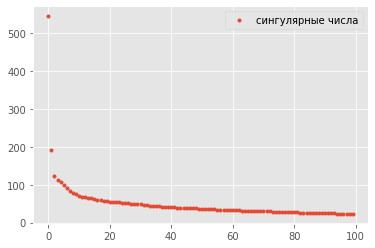

In [17]:
plt.plot(pca.singular_values_[:100], '.')
plt.legend(['сингулярные числа'])

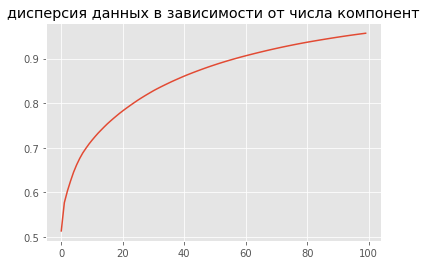

In [18]:
plt.plot(pca.explained_variance_ratio_.cumsum()[:100])
_=plt.title('дисперсия данных в зависимости от числа компонент')

# 10 компонент пусть будет по критерию сломанной трости
# столько компонент хватает, чтобы с хорошей точностью охарактеризовать датасет

In [19]:
# в итоге в X_new будет датасет примерно 1000 на 10, его будем кластеризовать

X_new = PCA(10).fit_transform(scaled_df)

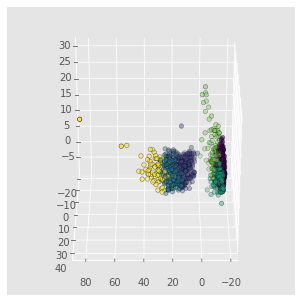

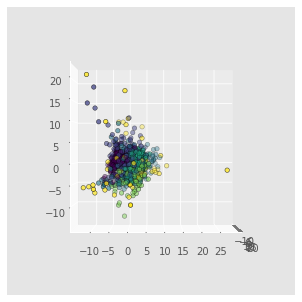

In [20]:
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=0).fit(X_new)

# первые три компоненты (из десяти)
fig = plt.figure(figsize=(4, 4))
ax = Axes3D(fig, elev=30, azim=90)
labels = kmeans.labels_
ax.scatter(X_new[:, 0], X_new[:, 1], X_new[:, 2],
           c=labels.astype(np.float), edgecolor='k')

# четвертая, пятая, шестая компоненты (из десяти)
fig = plt.figure(figsize=(4, 4))
ax = Axes3D(fig, elev=0, azim=0)
labels = kmeans.labels_
ax.scatter(X_new[:, 3], X_new[:, 4], X_new[:, 5],
           c=labels.astype(np.float), edgecolor='k')


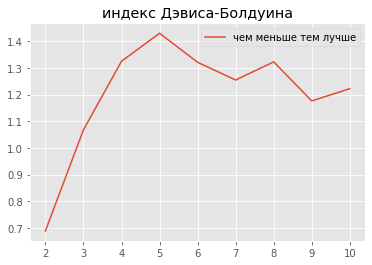

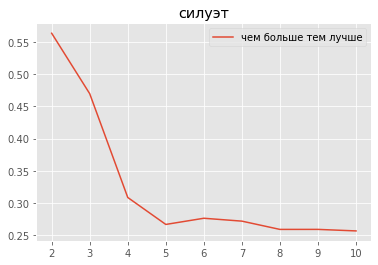

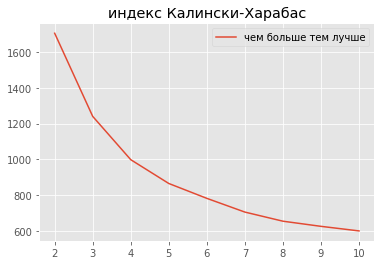

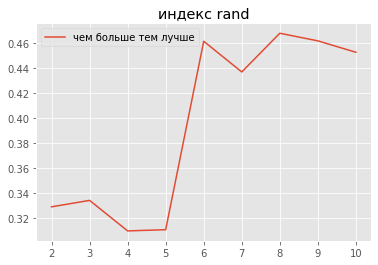

In [215]:
from sklearn.metrics.cluster import davies_bouldin_score,\
                                    silhouette_score,\
                                    calinski_harabasz_score,\
                                    adjusted_rand_score

scores = {'индекс Дэвиса-Болдуина':[],
          'силуэт':[],
          'индекс Калински-Харабас':[],
          'индекс rand':[]}

for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_new)
    scores['индекс Дэвиса-Болдуина'] += [davies_bouldin_score(X_new, kmeans.labels_)]
    scores['силуэт'] += [silhouette_score(X_new, kmeans.labels_)]
    scores['индекс Калински-Харабас'] += [calinski_harabasz_score(X_new, kmeans.labels_)]
    scores['индекс rand'] += [adjusted_rand_score(y, kmeans.labels_)]

bigger_or_smaller = {'индекс Дэвиса-Болдуина':'меньше',
                      'силуэт':'больше',
                      'индекс Калински-Харабас':'больше',
                      'индекс rand':'больше'}
    
for index_type in scores.keys():
    plt.plot(range(2,11), scores[index_type])
    plt.title(index_type)
    plt.legend([f'чем {bigger_or_smaller[index_type]} тем лучше'])
    plt.show()

In [23]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

In [24]:
distance_matrix = pairwise_distances(X_new)

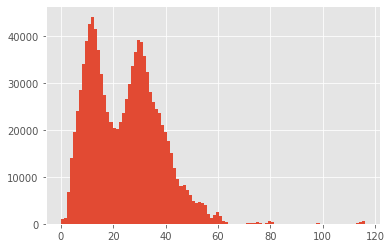

In [25]:
_=plt.hist(distance_matrix.flatten(), bins=100)

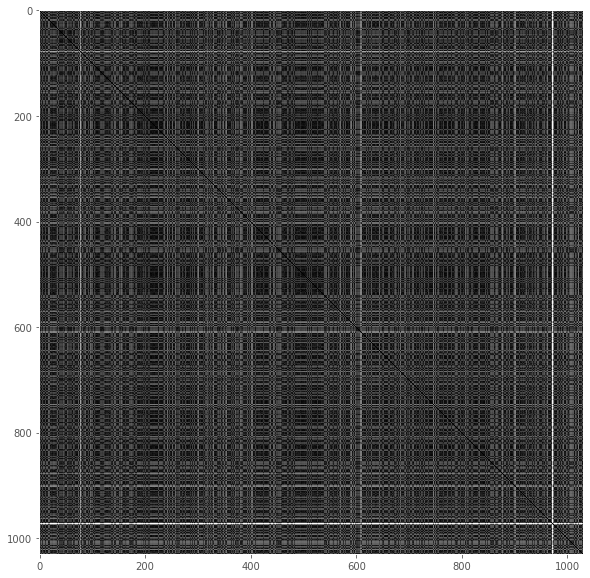

In [26]:
# матрица расстояний (чем ярче тем больше расстояние)

plt.figure(figsize=(10,10))
plt.imshow(distance_matrix, cmap='gray',)
plt.grid(b=None)


In [26]:
type(distance_matrix)

numpy.ndarray

In [27]:
clustering = AgglomerativeClustering(n_clusters=6).fit(distance_matrix)


C:\Users\Vova\miniconda3\lib\site-packages\scipy\cluster\hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


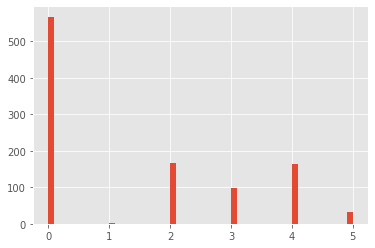

In [30]:
_=plt.hist(clustering.labels_, bins=50)

In [37]:
distance_matrix[[1,2,3], [1,2,3]]

array([0., 0., 0.])

In [38]:
# переупорядочивание в согласии с кластерами

lst = sorted(enumerate(clustering.labels_), key=lambda tpl: tpl[1])
clustering_order = [tpl[0] for tpl in lst]

clustering_order_distance_matrix = distance_matrix[clustering_order, :][:, clustering_order]

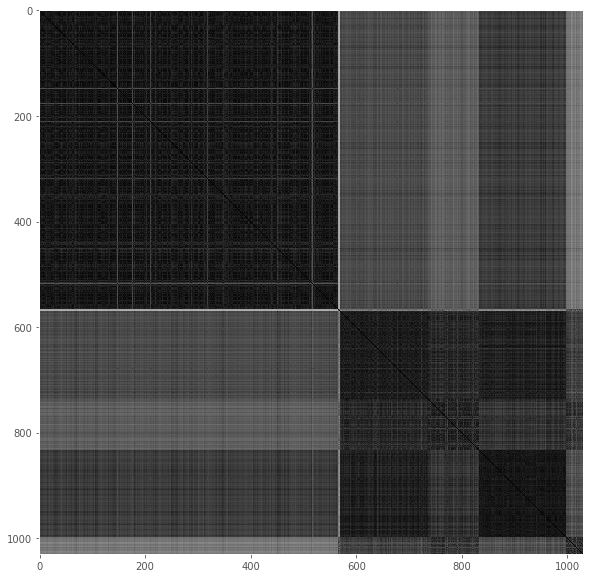

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(clustering_order_distance_matrix, cmap='gray',)
plt.grid(b=None)

In [42]:
from sklearn.cluster import DBSCAN

In [193]:
# параметр eps говорит какое расстояние должно быть у соседей (у соседей < eps)
# параметр min_samples говорит сколько должно быть соседей включая саму точку, чтобы ее можно было считать частью скопления

dbscan_clustering = DBSCAN(eps=50, min_samples=3).fit(distance_matrix)

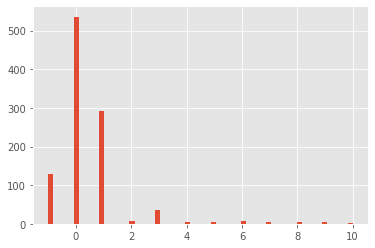

In [194]:
_=plt.hist(dbscan_clustering.labels_, bins=60)

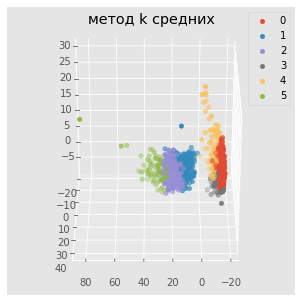

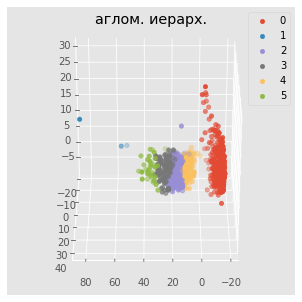

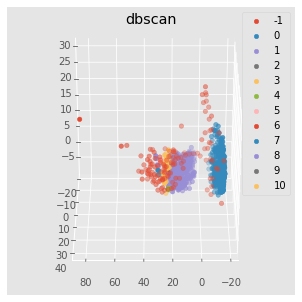

In [216]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(X_new)
for model, title in zip([kmeans, clustering, dbscan_clustering], ['метод k средних','аглом. иерарх.', 'dbscan']):

    fig = plt.figure(figsize=(4, 4))
    ax = Axes3D(fig, elev=30, azim=90)
    for cluster_number in sorted(set(model.labels_)):
        mask = model.labels_ == cluster_number
        ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], )
    plt.title(title)
    plt.legend(sorted(set(model.labels_)))
    plt.show()
